In [1]:
!pip install missingno

In [3]:
!pip install xgboost

In [1]:
from typing import List, Optional
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns
import scipy.stats as st
from scipy.stats import probplot, ks_2samp

from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_is_fitted
import missingno as msno
import xgboost as xgb
%matplotlib inline

In [2]:
train = pd.read_csv("assignment1_data/train.csv")
test = pd.read_csv("assignment1_data/test.csv")

print("train.shape = {} rows, {} cols".format(*train.shape))
print("test.shape = {} rows, {} cols".format(*test.shape))

train.shape = 200000 rows, 202 cols
test.shape = 200000 rows, 201 cols


Одна из самых простых вещей, которые мы можем сделать с новым набором данных - посчитать базовые статистики по набору данных. Базовые статистики - достаточно широкий термин: мы можем интерпретировать его как быстрый и примерный способ получить некоторую информацию о данных, как способ получить простую, легкую для понимания информацию о данных, чтобы получить базовое представление о данных. Мы можем использовать метод __describe__ для получения сводной статистики по всем значениям, за иключением пропусков.

In [3]:
train.describe()

,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,...,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,0.100490,10.679914,-1.627622,10.715192,6.796529,11.078333,-5.065317,5.408949,16.545850,0.284162,...,3.234440,7.438408,1.927839,3.331774,17.993784,-0.142088,2.303335,8.908158,15.870720,-3.326537
std,0.300653,3.040051,4.050044,2.640894,2.043319,1.623150,7.863267,0.866607,3.418076,3.332634,...,4.559922,3.023272,1.478423,3.992030,3.135162,1.429372,5.454369,0.921625,3.010945,10.438015
min,0.000000,0.408400,-15.043400,2.117100,-0.040200,5.074800,-32.562600,2.347300,5.349700,-10.505500,...,-14.093300,-2.691700,-3.814500,-11.783400,8.694400,-5.261000,-14.209600,5.960600,6.299300,-38.852800
25%,0.000000,8.453850,-4.740025,8.722475,5.254075,9.883175,-11.200350,4.767700,13.943800,-2.317800,...,-0.058825,5.157400,0.889775,0.584600,15.629800,-1.170700,-1.946925,8.252800,13.829700,-11.208475
50%,0.000000,10.524750,-1.608050,10.580000,6.825000,11.108250,-4.833150,5.385100,16.456800,0.393700,...,3.203600,7.347750,1.901300,3.396350,17.957950,-0.172700,2.408900,8.888200,15.934050,-2.819550
75%,0.000000,12.758200,1.358625,12.516700,8.324100,12.261125,0.924800,6.003000,19.102900,2.937900,...,6.406200,9.512525,2.949500,6.205800,20.396525,0.829600,6.556725,9.593300,18.064725,4.836800
max,1.000000,20.315000,10.376800,19.353000,13.188300,16.671400,17.251600,8.447700,27.691800,10.151300,...,18.440900,16.716500,8.402400,18.281800,27.928800,4.272900,18.321500,12.000400,26.079100,28.500700


После того, как мы получили общее представление о наборе данных, стоит поближе вглянуть на сами данные. С помощью методов __head()__, __tail()__ мы можем легко посмотреть начало и конец pandas.DataFrame, в котором сосредоточены данные.

In [4]:
train.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


Теперь, давайте перейдем к анализу числовых признаков

In [5]:
numerical_features = train.select_dtypes(include=[np.number])
print(f"count of numeric_features {numerical_features.shape[1]}")

numerical_features.columns

count of numeric_features 201


Index(['target', 'var_0', 'var_1', 'var_2', 'var_3', 'var_4', 'var_5', 'var_6',
       'var_7', 'var_8',
       ...
       'var_190', 'var_191', 'var_192', 'var_193', 'var_194', 'var_195',
       'var_196', 'var_197', 'var_198', 'var_199'],
      dtype='object', length=201)

In [6]:
numerical_features.head(n=2)

,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,0,8.9255,-6.7863,11.9081,5.093,11.4607,-9.2834,5.1187,18.6266,-4.9200,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,0,11.5006,-4.1473,13.8588,5.389,12.3622,7.0433,5.6208,16.5338,3.1468,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518


## Анализ числовых переменных

## Дескретные признаки

In [9]:
discrete_feature = [
    feature for feature in numerical_features
    if len(train[feature].unique())<25 and feature not in year_feature+["Id"]
]

print(f"Discrete Variables Count: {len(discrete_feature)}")

Discrete Variables Count: 1


In [10]:
train[discrete_feature].head()

,target
0,0
1,0
2,0
3,0
4,0


In [12]:
train['target'].unique()

array([0, 1], dtype=int64)

Значит задача классификации!

## Непрерывные признаки

In [13]:
continuous_feature = [
    feature for feature in numerical_features
    if feature not in discrete_feature + year_feature + ["Id"]]

print(f"Continuous Feature Count {len(continuous_feature)}")

Continuous Feature Count 200


Для непрерывные признаков имеет смысл строить гистрограммы распределения или функции распределения, а также зависимость непрерывного признака в разрезе целевой переменной. Кроме того, имеет смысл строить распределение __одновременно__ и для обучающей выборки, и для тестовой для понимания насколько отличаются распределения.

## Категориальные признаки

In [17]:
categorical_features = train.select_dtypes(include=[np.object])
print(f"Categorical Feature Count {categorical_features.shape[1]}")
categorical_features.head(n=10)

Categorical Feature Count 1


,ID_code
0,train_0
1,train_1
2,train_2
3,train_3
4,train_4
5,train_5
6,train_6
7,train_7
8,train_8
9,train_9


## Анализ пропусков

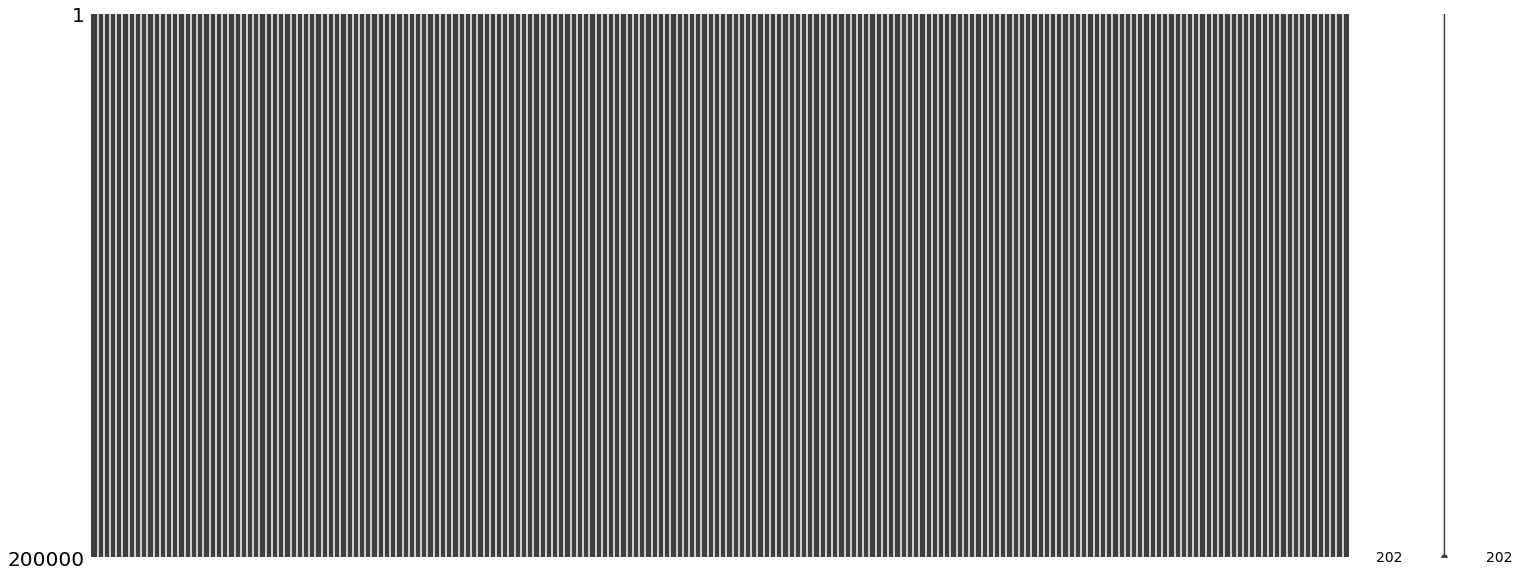

In [18]:
msno.matrix(train)

In [22]:
train[feature].isnull().sum()

0

Вывод: пропусков нет

2. Сделать базовый анализ целевой переменной, сделать выводы;

In [28]:
len(train[train['target'] == 1])

20098

In [29]:
len(train[train['target'] == 0])

179902

Вывод: классы на тренировочном наборе не сбалансированы. Требуется балансировка.

3. Построить распределение признаков в зависимости от значения целевой переменной и распределение признаков для обучающей и тестовой выборки (если машина не позволяет построить распределение для всех признаков, то выполнить задание для признаков var_0, var_1, var_2, var_5, var_9, var_10, var_13, var_20, var_26, var_40, var_55, var_80, var_106, var_109, var_139, var_175, var_184, var_196), сделать выводы;


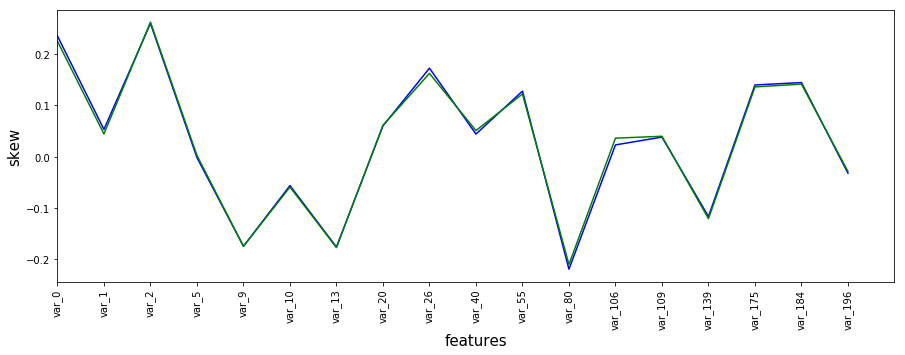

In [46]:
lst_col = ['var_0','var_1','var_2','var_5','var_9','var_10','var_13','var_20','var_26','var_40','var_55','var_80','var_106','var_109','var_139','var_175','var_184','var_196']
data = train[lst_col].copy()
data_test = test[lst_col].copy()

fig = plt.figure(figsize=(15, 5))
train_stats, test_stats = data.skew(), data_test.skew()
plt.plot(train_stats, color="blue", label="train")
plt.plot(test_stats, color="green", label="test")
plt.xticks(range(train_stats.shape[0]), train_stats.index, rotation=90)
plt.xlabel("features", size=15)
plt.xlim(0, len(train_stats))
plt.ylabel("skew", size=15)
plt.show()

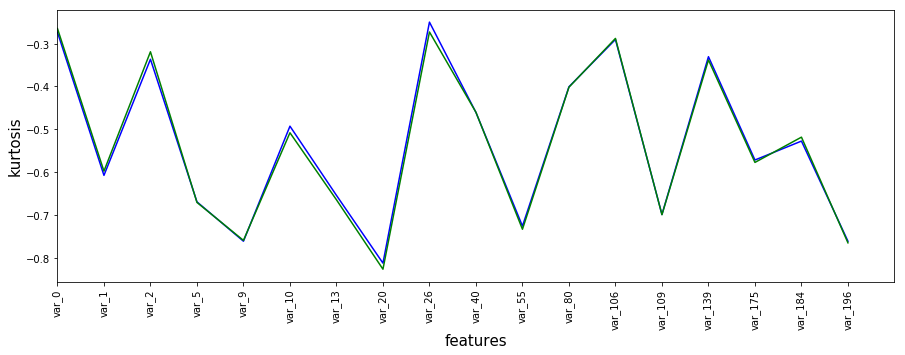

In [36]:
fig = plt.figure(figsize=(15, 5))
train_stats, test_stats = data.kurtosis(), data_test.kurtosis()
plt.plot(train_stats, color="blue", label="train")
plt.plot(test_stats, color="green", label="test")
plt.xticks(range(train_stats.shape[0]), train_stats.index, rotation=90)
plt.xlabel("features", size=15)
plt.ylabel("kurtosis", size=15)
plt.xlim(0, len(train_stats))
plt.show()

Вывод: распределение признаков на тренировочном и тестовом наборах совпадают.

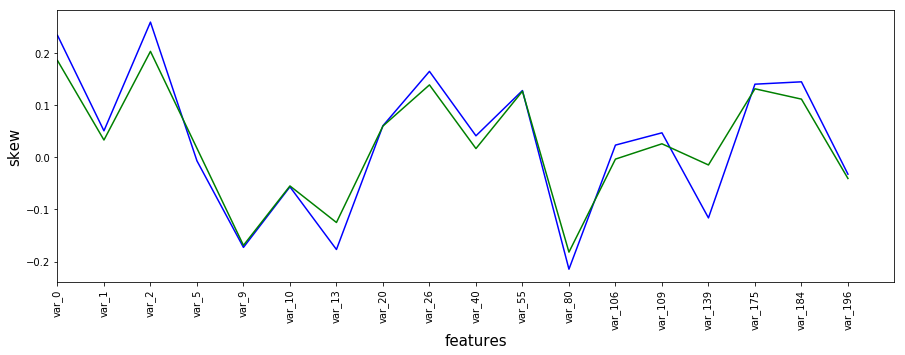

In [40]:
data0 = data[train['target'] == 0].copy()
data1 = data[train['target'] == 1].copy()

fig = plt.figure(figsize=(15, 5))
train0_stats, train1_stats = data0.skew(), data1.skew()
plt.plot(train0_stats, color="blue", label="target=0")
plt.plot(train1_stats, color="green", label="target=1")
plt.xticks(range(train0_stats.shape[0]), train0_stats.index, rotation=90)
plt.xlabel("features", size=15)
plt.xlim(0, len(train_stats))
plt.ylabel("skew", size=15)
plt.show()

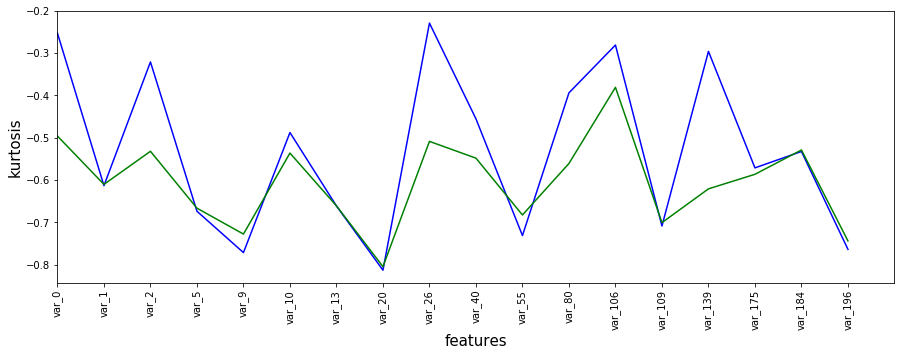

In [41]:
fig = plt.figure(figsize=(15, 5))
train0_stats, train1_stats = data0.kurtosis(), data1.kurtosis()
plt.plot(train0_stats, color="blue", label="train")
plt.plot(train1_stats, color="green", label="test")
plt.xticks(range(train0_stats.shape[0]), train0_stats.index, rotation=90)
plt.xlabel("features", size=15)
plt.ylabel("kurtosis", size=15)
plt.xlim(0, len(train_stats))
plt.show()

4. Построить распределение основных статистики признаков (среднее, стандартное отклонение) в разрезе целевой переменной и распределение основных статистик обучающей и тестовой выборки, сделать выводы;


In [50]:
data.describe()

,var_0,var_1,var_2,var_5,var_9,var_10,var_13,var_20,var_26,var_40,var_55,var_80,var_106,var_109,var_139,var_175,var_184,var_196
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,10.679914,-1.627622,10.715192,-5.065317,7.567236,0.394340,8.530232,13.290894,-4.055133,-6.725505,12.745852,5.795044,8.617657,18.458001,7.760193,11.640613,12.756676,2.303335
std,3.040051,4.050044,2.640894,7.863267,1.235070,5.500793,4.639536,5.876254,5.922210,8.279259,5.690072,7.436737,1.894899,4.355031,7.686433,2.892167,9.318280,5.454369
min,0.408400,-15.043400,2.117100,-32.562600,3.970500,-20.731300,-6.011100,-5.432200,-24.243100,-35.211700,-3.782600,-18.042200,0.942400,5.769700,-21.274300,3.241500,-18.489700,-14.209600
25%,8.453850,-4.740025,8.722475,-11.200350,6.618800,-3.594950,5.072800,8.627800,-8.321725,-12.831825,8.163900,0.694475,7.282300,15.107175,2.387575,9.371600,5.663300,-1.946925
50%,10.524750,-1.608050,10.580000,-4.833150,7.629600,0.487300,8.604250,13.196800,-4.196900,-6.617450,12.594100,6.061750,8.605150,18.281350,8.066250,11.679800,12.521000,2.408900
75%,12.758200,1.358625,12.516700,0.924800,8.584425,4.382925,12.274775,17.879400,-0.090200,-0.880875,17.086625,11.449125,9.928900,21.852900,13.232525,13.745500,19.456150,6.556725
max,20.315000,10.376800,19.353000,17.251600,11.150600,18.670200,22.331500,31.285900,15.675100,18.105600,29.092100,30.476900,15.307400,32.059100,36.097100,20.854800,44.363400,18.321500


In [51]:
data_test.describe()

,var_0,var_1,var_2,var_5,var_9,var_10,var_13,var_20,var_26,var_40,var_55,var_80,var_106,var_109,var_139,var_175,var_184,var_196
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,10.658737,-1.624244,10.707452,-5.050558,7.569407,0.371335,8.540872,13.298428,-3.983721,-6.736054,12.756876,5.815081,8.621051,18.455457,7.765888,11.635715,12.719302,2.290899
std,3.036716,4.040509,2.633888,7.869293,1.231865,5.508661,4.628712,5.884245,5.945853,8.298827,5.699920,7.427520,1.890661,4.368647,7.683951,2.884821,9.316889,5.446346
min,0.188700,-15.043400,2.355200,-27.767000,4.243300,-22.672400,-4.741300,-2.634600,-24.536100,-34.952400,-3.275100,-16.704500,1.064800,5.078200,-21.274300,2.951200,-17.011400,-13.944200
25%,8.442975,-4.700125,8.735600,-11.201400,6.623800,-3.626000,5.073375,8.589600,-8.265500,-12.878300,8.130400,0.721275,7.285400,15.084800,2.439000,9.382575,5.631700,-1.948600
50%,10.513800,-1.590500,10.560700,-4.834100,7.632000,0.491850,8.617400,13.218650,-4.125800,-6.615750,12.650600,6.046850,8.605350,18.280600,8.035900,11.668400,12.493350,2.403600
75%,12.739600,1.343400,12.495025,0.942575,8.584825,4.362400,12.270900,17.914200,-0.000700,-0.899000,17.101150,11.432875,9.926125,21.861700,13.246525,13.748500,19.437600,6.519800
max,22.323400,9.385100,18.714100,17.253700,11.003600,20.214500,21.605100,32.075800,13.456400,17.071700,29.802300,28.180700,15.274300,32.173400,37.730400,19.892200,44.363400,15.920700


Тренировочный и тестовый наборы данных очень похожи.

In [52]:
data0.describe()

,var_0,var_1,var_2,var_5,var_9,var_10,var_13,var_20,var_26,var_40,var_55,var_80,var_106,var_109,var_139,var_175,var_184,var_196
count,179902.000000,179902.000000,179902.000000,179902.000000,179902.000000,179902.000000,179902.000000,179902.000000,179902.000000,179902.000000,179902.000000,179902.000000,179902.000000,179902.000000,179902.000000,179902.000000,179902.000000,179902.000000
mean,10.626681,-1.695770,10.665876,-5.146736,7.584907,0.398410,8.615764,13.326894,-4.178694,-6.862568,12.713185,5.938240,8.596790,18.530675,7.950512,11.619644,12.606196,2.260297
std,3.008564,4.024813,2.612961,7.827522,1.228839,5.499197,4.603038,5.871569,5.847831,8.215720,5.680993,7.352254,1.885447,4.322076,7.587266,2.883026,9.262205,5.441118
min,0.408400,-15.043400,2.117100,-32.562600,3.970500,-20.731300,-6.011100,-5.432200,-24.243100,-35.211700,-3.782600,-18.042200,0.942400,5.769700,-21.274300,3.241500,-18.489700,-14.209600
25%,8.429500,-4.790775,8.698025,-11.260950,6.637500,-3.586100,5.168700,8.664650,-8.385275,-12.924100,8.133800,0.864150,7.269100,15.178025,2.660425,9.359050,5.542200,-1.987375
50%,10.478600,-1.682600,10.529000,-4.917700,7.645600,0.491600,8.689700,13.228200,-4.298600,-6.760750,12.557300,6.209800,8.584700,18.353300,8.236550,11.648800,12.351000,2.359700
75%,12.693075,1.287700,12.463900,0.844600,8.598075,4.379575,12.334400,17.920200,-0.239100,-1.032325,17.051250,11.517675,9.898350,21.906650,13.330350,13.720275,19.294350,6.513425
max,20.315000,10.376800,19.353000,17.251600,11.150600,18.670200,22.331500,31.285900,15.675100,18.105600,29.092100,30.476900,15.307400,32.059100,36.097100,20.854800,44.363400,18.321500


In [53]:
data1.describe()

,var_0,var_1,var_2,var_5,var_9,var_10,var_13,var_20,var_26,var_40,var_55,var_80,var_106,var_109,var_139,var_175,var_184,var_196
count,20098.000000,20098.000000,20098.000000,20098.000000,20098.000000,20098.000000,20098.000000,20098.000000,20098.000000,20098.000000,20098.000000,20098.000000,20098.000000,20098.000000,20098.000000,20098.000000,20098.000000,20098.000000
mean,11.156418,-1.017613,11.156633,-4.336522,7.409064,0.357916,7.764618,12.968654,-2.949112,-5.498624,13.038255,4.513254,8.804442,17.807484,6.056607,11.828309,14.103659,2.688583
std,3.270293,4.220638,2.841075,8.140281,1.278709,5.515060,4.888186,5.908411,6.446004,8.732590,5.762603,8.041483,1.967711,4.588738,8.331637,2.966222,9.702796,5.556892
min,0.452800,-14.037000,2.946200,-28.246100,4.186100,-18.386600,-4.966100,-1.625800,-23.281000,-31.971000,-2.945400,-16.704500,1.257400,6.327800,-16.415400,3.914900,-15.139200,-14.020400
25%,8.695875,-4.203475,8.961125,-10.615800,6.451575,-3.670500,4.227425,8.274425,-7.720300,-11.955575,8.443725,-0.867100,7.402525,14.420850,0.162800,9.500500,6.755250,-1.572225
50%,11.001350,-0.992650,11.096700,-4.101950,7.484950,0.446300,7.927700,12.932750,-3.117950,-5.370400,12.929550,4.561700,8.804250,17.647050,6.182450,11.805050,13.955300,2.831050
75%,13.343700,2.001375,13.047025,1.619950,8.437200,4.412475,11.646650,17.534325,1.359500,0.479375,17.373025,10.699150,10.180125,21.328900,12.271875,13.977225,20.924000,6.956250
max,19.458300,9.029800,18.294100,16.423600,10.588100,16.800300,20.745900,30.475700,14.746600,16.799400,28.180300,28.285700,15.200300,30.874100,32.269900,19.608000,41.650400,17.161400


Никаких интересных закономерносей в признаках, позволяющих сразу определить целевую переменную по 1 признаку без машинного обучения, обнаружить не удалось.

5. Построить распределение коэффициентов корреляции между признаками. Есть ли зависимость между признаками (будем считать, что связь между признаками отсутствует, если коэффициент корреляции < 0.2)?

Для дальнейшего изучения взаимосвязи признаков будем использовать:
* Correlation Heat Map
* Heat Map для отдельных признаков
* Pair Plot
* Scatter Plot

## Корреляция между числовыми признаками

In [55]:
correlation = numerical_features.corr()
corr_with_target = correlation["target"].sort_values(ascending = False)
corr_with_target

target     1.000000
var_6      0.066731
var_110    0.064275
var_53     0.063399
var_26     0.062422
var_22     0.060558
var_99     0.058367
var_190    0.055973
var_2      0.055870
var_133    0.054548
var_0      0.052390
var_1      0.050343
var_179    0.050002
var_40     0.049530
var_184    0.048315
var_78     0.048245
var_170    0.047973
var_191    0.047114
var_94     0.046296
var_67     0.044673
var_18     0.043479
var_173    0.042022
var_164    0.040997
var_118    0.040358
var_147    0.040280
var_91     0.040127
var_89     0.039369
var_95     0.038531
var_155    0.037240
var_35     0.036567
             ...   
var_86    -0.039126
var_121   -0.039788
var_107   -0.039997
var_123   -0.040291
var_122   -0.042461
var_9     -0.042805
var_192   -0.042858
var_33    -0.044334
var_108   -0.044791
var_154   -0.046106
var_92    -0.046295
var_149   -0.047319
var_169   -0.048382
var_44    -0.049039
var_109   -0.049926
var_115   -0.050174
var_34    -0.052692
var_198   -0.053000
var_148   -0.055011


линейная корреляция отсутвует.

## Correlation Heat Map

Тепловая карта - лучший способ __быстро__ получить информацию о силе связи между переменными. 

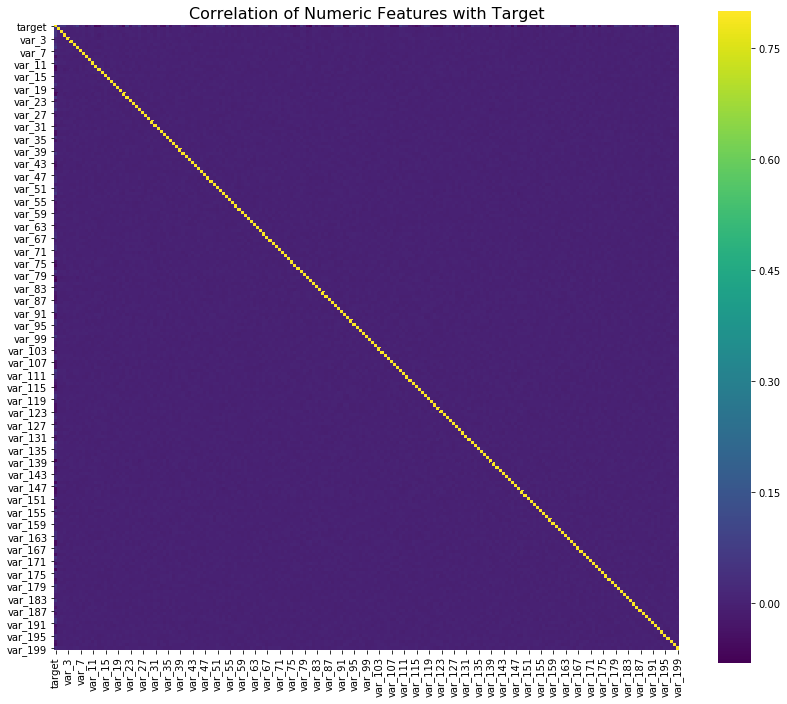

In [56]:
fig, axes = plt.subplots(figsize = (14,12))
plt.title("Correlation of Numeric Features with Target", y=1, size=16)
sns.heatmap(correlation, square=True, vmax=0.8, cmap="viridis")

Полное отсутвие взаимных линейных корреляций между признаками.

6. Выявить 10 признаков, которые обладают наибольшей нелинейной связью с целевой переменной.

## Нелинейная связь между признаками

Коэффициент корреляции позволяет установить линейную силу связи между признаками, но также признаки могут быть связаны нелинейно, что сложно определяется коэффициентом корреляции: может быть ситуация, что признаки очень сильно связаны между собой, но коэффициент корреляции равен 0. 

Для начала давайте воспользуемся случайным лесом, чтобы выбрать 10 наиболее значимых признаков. Они могут служить отправной точкой для понимания природы данных и общего понимания данные. Кроме того, они могут дать некоторые идеи о том, как создавать новые признаки. Давайте начнем!

In [58]:
%%time
parameters = {"max_depth": 6, "n_estimators": 25, "random_state": 27, "n_jobs": 2}

forest = RandomForestRegressor(**parameters)
forest.fit(numerical_features.fillna(-9999).drop("target", axis=1), target)

Wall time: 4min 16s


Text(0.5, 1.0, 'What are the top important features to start with?')

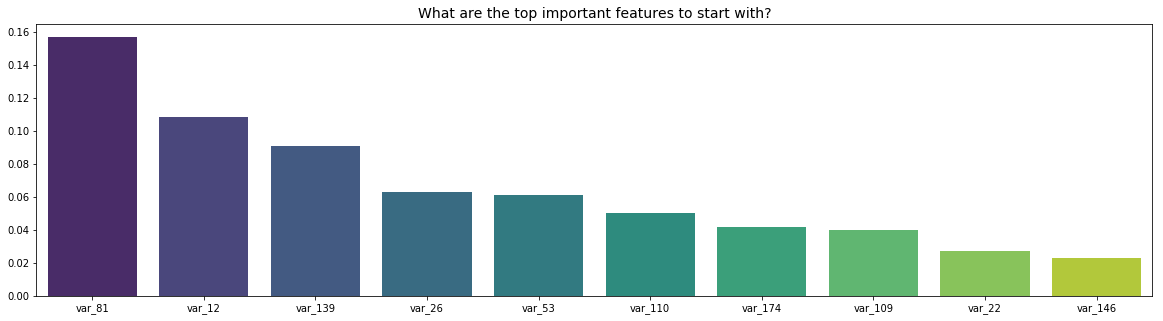

In [60]:
n_top = 10
importances = forest.feature_importances_
idx = np.argsort(importances)[::-1][0:n_top]
feature_names = numerical_features.drop("target", axis=1).columns

plt.figure(figsize=(20, 5))
sns.barplot(x=feature_names[idx], y=importances[idx], palette="viridis")
plt.title("What are the top important features to start with?", size=14)

## Pair Plot

PairPlor между `target` и высоко-коррелированными переменными. Строим этот график для лучшего понимания характерика связи между целевой переменной и признаком. С помощью корреляционной матрицы мы установили что связь между определенными признаками и целевой переменной есть, но характер этой связи пока остается невыясненным. Строим PairPlot для лучшего понимания характера этой связи;

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


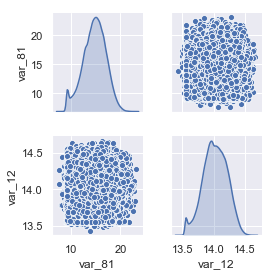

In [61]:
sns.set()
columns = [
    "var_81",
    "var_12"
]

sns.pairplot(train[columns], size=2, kind="scatter", diag_kind="kde")
plt.show()

7. Провести анализ идентичности распределения признаков на обучающей и тестовой выборках, сделать выводы.

## Анализ распределения на обучении и тесте

Совпадение распределений на выборке для обучения и для тестирования - одна из ключевых коцепций статистического обучения. Обучая модель на некоторых данных, мы принимаем гипотезу о том, что модель должна работать на таких же данных.

## Kolmogorov-Smirnov Test

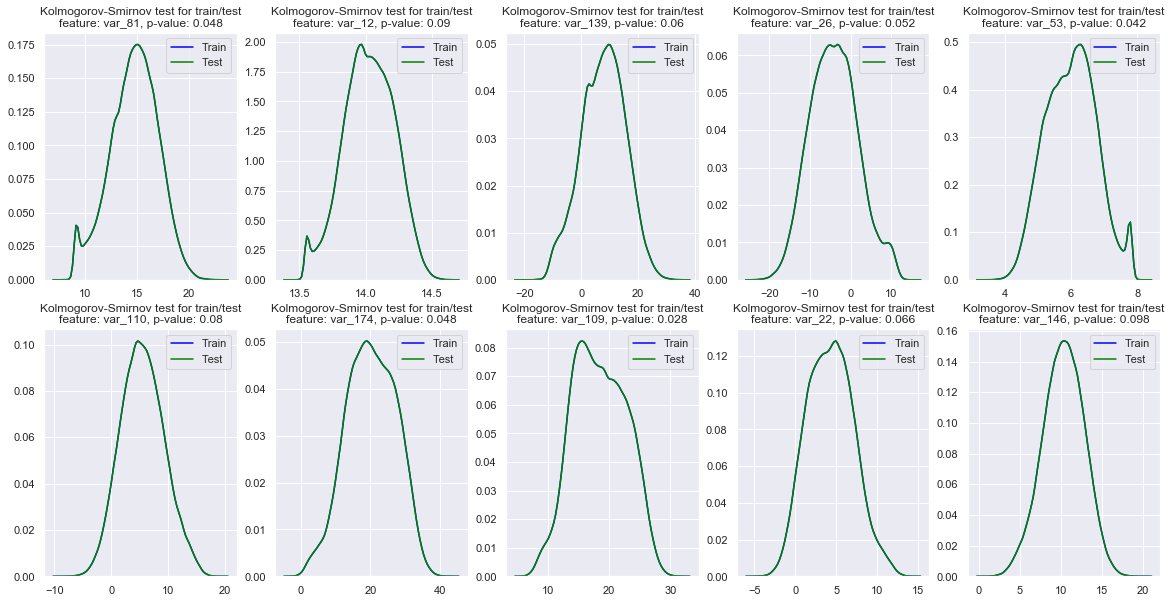

In [62]:
statistics_array = []
fig, axes = plt.subplots(2, 5, figsize=(20, 10))

for num, feature in enumerate(feature_names[idx]):
    statistic, pvalue = ks_2samp(
        train[feature].sample(500), test[feature].sample(500)
    )
    statistics_array.append(statistic)

    sns.kdeplot(train[feature], ax=axes[num//5, num%5], color="Blue", label="Train")
    sns.kdeplot(train[feature], ax=axes[num//5, num%5], color="Green", label="Test")

    axes[num//5, num%5].set_title(
        (f"Kolmogorov-Smirnov test for train/test\n"
        f"feature: {feature}, p-value: {round(statistic, 3)}")
    )

## Population Stability Index

In [63]:
class PSI(BaseEstimator, TransformerMixin):
    """
    Вычисление PSI и отбор признаков на их основе.

    Parameters
    ----------
    threshold: float
        Порог для отбора переменных по PSI.
        Если PSI для переменной выше порога - переменная макрируется
        0 (не использовать для дальнейшего анализа), если ниже
        порога - маркируется 1 (использовать для дальнейшего анализа).

    categorical_features: List[str], optional, default = None
        Список категориальных признаков для анализа.
        Опциональный параметр, по умолчанию, не используется, т.е.
        категориальные признаки отсутствуют.

    n_bins: int, optional, default = 20
        Количество бинов, на которые разбивается выборка.

    min_value: float, optional, default = 0.005
        Значение которое используется, если рассчитанный psi = 0.

    bin_type: string, optional, default = "quanitles"
        Способ разбиения на бины: "quantiles" or "bins".
        При выборе "quantiles" - выборка будет разбита на n_bins
        квантилей, при выборке "bins" - выборка будет разбита на
        n_bins бакетов с равным шагом между бакетами.
        Иные значения приводят к возникновению ValueError.

    Attributes
    ----------
    scores_: Dict[str, float]
        Словарь со значениями PSI,
        ключ словаря - название признака, значение - PSI-score.

    """
    def __init__(self,
                 threshold: float,
                 categorical_features: Optional[List[str]] = None,
                 bin_type: str = "quantiles",
                 min_value: float = 0.005,
                 n_bins: int = 20):

        self.threshold = threshold
        self.categorical_features = categorical_features
        self.min_value = min_value
        self.n_bins = n_bins
        if bin_type in ["quantiles", "bins"]:
            self.bin_type = bin_type
        else:
            raise ValueError(
                "Incorrect bin_type value. Expected 'quantiles' or 'bins', "
                f"but {bin_type} is transferred."
            )
        self.scores = {}

    def calculate_bins(self, data: pd.Series) -> np.array:
        """
        Вычисление границ бинов для разбиения выборки.

        Parameters
        ----------
        data: pandas.Series, shape = [n_samples, ]
            наблюдения из train-выборки.

        Returns
        -------
        bins: numpy.array, shape = [self.n_bins + 1]
            Список с границами бинов.

        """
        if self.bin_type == "quantiles":
            bins = np.linspace(0, 100, self.n_bins + 1)
            bins = [np.nanpercentile(data, x) for x in bins]

        else:
            bins = np.linspace(data.min(), data.max(), self.n_bins + 1)

        return np.unique(bins)

    def calculate_psi_in_bin(self, expected_score, actual_score) -> float:
        """
        Вычисление значения psi для одного бакета.

        Осуществляется проверка на равенство нулю expected_score и
        actual_score: если один из аргументов равен нулю, то его
        значение заменяется на self.min_value.

        Parameters
        ----------
        expected_score: float
            Ожидаемое значение.

        actual_score: float
            Наблюдаемое значение.

        Returns
        -------
        value: float
            Значение psi в бине.

        """
        if expected_score == 0:
            expected_score = self.min_value
        if actual_score == 0:
            actual_score = self.min_value

        value = (expected_score - actual_score)
        value = value * np.log(expected_score / actual_score)

        return value

    def calculate_psi(self, expected: pd.Series, actual: pd.Series, bins) -> float:
        """
        Расчет PSI для одной переменной.

        Parameters
        ----------
        expected: pandas.Series, shape = [n_samples_e, ]
            Наблюдения из train-выборки.

        actual: pandas.Series, shape = [n_samples_o, ]
            Наблюдения из test-выборки.

        bins: pandas.Series, shape = [self.n_bins, ]
            Бины для расчета PSI.

        Returns
        -------
        psi_score: float
            PSI-значение для данной пары выборок.

        """
        expected_score = np.histogram(expected.fillna(-9999), bins)[0]
        expected_score = expected_score / expected.shape[0]

        actual_score = np.histogram(actual.fillna(-9999), bins)[0]
        actual_score = actual_score / actual.shape[0]

        psi_score = np.sum(
            self.calculate_psi_in_bin(exp_score, act_score)
            for exp_score, act_score in zip(expected_score, actual_score)
        )

        return psi_score

    def calculate_numeric_psi(self, expected: pd.Series, actual: pd.Series) -> float:
        """
        Вычисление PSI для числовой переменной.

        Parameters
        ----------
        expected: pandas.Series, shape = [n_samples_e, ]
            Наблюдения из train-выборки.

        actual: pandas.Series, shape = [n_samples_o, ]
            Наблюдения из test-выборки.

        Returns
        -------
        psi_score: float
            PSI-значение для данной пары выборок.

        """
        bins = self.calculate_bins(expected)
        psi_score = self.calculate_psi(expected, actual, bins)
        return psi_score

    def calculate_categorical_psi(self, expected: pd.Series, actual: pd.Series) -> float:
        """
        Вычисление PSI для категориальной переменной.
        PSI рассчитывается для каждого уникального значения категории.

        Parameters
        ----------
        expected: pandas.Series, shape = [n_samples_e, ]
            Наблюдения из train-выборки.

        actual: pandas.Series, shape = [n_samples_o, ]
            Наблюдения из test-выборки.

        Returns
        -------
        psi_score: float
            PSI-значение для данной пары выборок.

        """
        bins = np.unique(expected).tolist()
        psi_score = self.calculate_psi(expected, actual, bins)
        return psi_score

    def fit(self, X, y=None):
        """
        Вычисление PSI-значения для всех признаков.

        Parameters
        ----------
        X: pandas.DataFrame, shape = [n_samples, n_features]
            Матрица признаков для обучения.

        y: pandas.DataFrame, shape = [n_samples, n_features]
            Матрица признаков для тестирования.

        Returns
        -------
        self
        """
        missed_columns = list(set(X.columns) - set(y.columns))

        if missed_columns:
            raise MissedColumnError(
                f"Missed {list(missed_columns)} columns in data.")

        if self.categorical_features:
            numeric_features = list(
                set(X.columns) - set(self.categorical_features)
            )
            for feature in self.categorical_features:
                self.scores[feature] = self.calculate_categorical_psi(
                    X[feature], y[feature]
                )
        else:
            numeric_features = X.columns

        for feature in tqdm(numeric_features):
            self.scores[feature] = self.calculate_numeric_psi(
                X[feature], y[feature]
            )
        return self

    def transform(self, X, y=None) -> pd.DataFrame:
        """
        Отбор переменных по self.threshold.
        Если PSI-score для переменной выше порога, то переменная
        помечается 0 (не использовать для дальнейшего анализа), если ниже
        порога - маркируется 1 (использовать для дальнейшего анализа).

        Parameters
        ----------
        data: pandas.DataFrame, shape = [n_samples, n_features]
            Матрица признаков для обучения.

        target: pandas.DataFrame, shape = [n_samples, n_features]
            Матрица признаков для тестирования.

        Returns
        -------
        scores: pandas.DataFrame, shape = [n_features, 3]
            Датафрейм с PSI-анализом переменных.

        """
        check_is_fitted(self, "scores")
        scores = pd.Series(self.scores)
        scores = pd.DataFrame({"Variable": scores.index, "PSI": scores.values})
        scores["Selected"] = np.where(scores.PSI < self.threshold, 1, 0)
        scores = scores.sort_values(by="PSI")

        mask = scores["Selected"] == 1
        self.used_features = scores.loc[mask, "Variable"].tolist()

        return scores.reset_index(drop=True)

In [67]:
features_to_score = numerical_features.drop(["target"], axis=1).columns.tolist()
psi = PSI(threshold=0.01)

In [68]:
psi.fit_transform(
    X=train[features_to_score],
    y=test[features_to_score]
)

100%|████████████████████████████████████████| 200/200 [00:15<00:00, 12.77it/s]


,Variable,PSI,Selected
0,var_154,0.000085,1
1,var_156,0.000132,1
2,var_5,0.000138,1
3,var_148,0.000150,1
4,var_35,0.000151,1
5,var_197,0.000168,1
6,var_36,0.000169,1
7,var_179,0.000179,1
8,var_71,0.000179,1
9,var_61,0.000183,1


## Adversarial Validation

In [69]:
X_adv = pd.concat([
    train[features_to_score], test[features_to_score]
])
y_adv = np.hstack(
    (np.ones(train.shape[0]), np.zeros(test.shape[0])))

X_adv = X_adv.reset_index(drop=True)

In [70]:
%%time
parameters = {"max_depth": 4, "n_estimators": 50, "random_state": 27, "n_jobs": 2}
model = xgb.XGBClassifier(**parameters)

cv = cross_val_score(
    estimator=model,
    X=X_adv, y=y_adv,
    scoring="roc_auc",
    cv=KFold(n_splits=3, shuffle=True, random_state=27)
)

print(f"CV-score: {round(np.mean(cv), 4)}")

CV-score: 0.5116
Wall time: 6min 29s


Text(0.5, 1.0, 'Top Importance Features for Adversarial Validation (train vs test)')

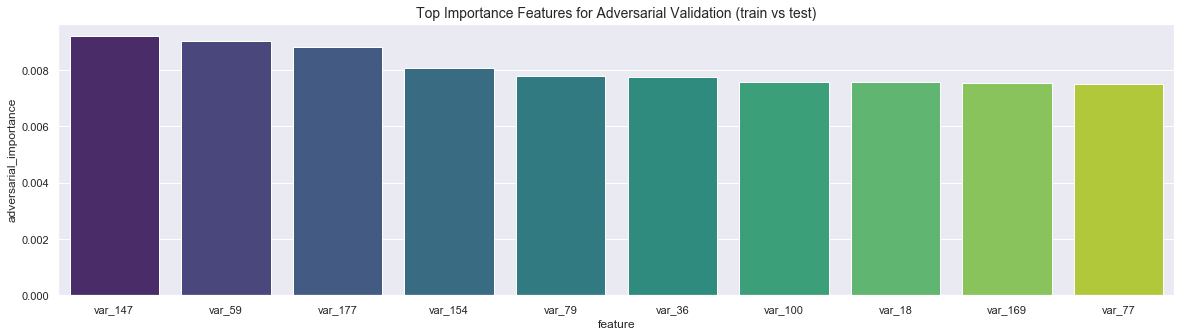

In [71]:
model.fit(X_adv, y_adv)

importance = pd.DataFrame({
    "feature": X_adv.columns,
    "adversarial_importance": model.feature_importances_
})
importance = importance.sort_values(by="adversarial_importance", ascending=False)
importance = importance.head(n=10)

plt.figure(figsize=(20, 5))
sns.barplot(x=importance["feature"], y=importance["adversarial_importance"], palette="viridis")
plt.title("Top Importance Features for Adversarial Validation (train vs test)", size=14)

Вывод: CV-score = 0.5 значит классификатор не смог разлчить тренировочный и тестовый набор. Это значит отличий в распределениях между ними не обнаружено.